In [1]:
import pandas as pd
import numpy as np
from lshash import LSHash
import random as rd

def input():

    # file input
    data = pd.read_csv('trade.csv', index_col=['uid'])

    # make groups
    grouped = data.groupby(['vipno', 'pluno'], as_index = False)
    
    # make sum
    grouped = grouped['amt'].agg(np.sum)

    # change type
    grouped[['vipno', 'pluno']] = grouped[['vipno', 'pluno']].astype('object')

    # merge
    total = pd.DataFrame(0, index=list(set(data['pluno'])), columns=list(set(data['vipno'])), dtype='int64')
    for index, row in grouped.iterrows():
       total.at[row['pluno'], row['vipno']] = int(np.floor(row['amt'] + 0.5))

    # convert
    data_array = total.as_matrix()
    return data_array, total, total.shape

def knn(data_array, data, hash_size_input, data_shape, vipno_pos, k):

    # init LSHash
    lsh = LSHash(hash_size=hash_size_input, input_dim=data_shape[0])

    # index
    for col_index in range(data_shape[1]):
        lsh.index(data_array[:, col_index], extra_data=data.columns[col_index])

    # calculate and output
    result = []
    for res in lsh.query(data_array[:, vipno_pos], num_results=k + 1, distance_func='euclidean'):
        result.append(res[0][1])

    return result[1:]

In [2]:
import random as rd
import math
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def evaluate_KMeans():

    # data input
    data_array, data, data_shape = input()
    data_array_transposed = data_array.transpose()

    # init k
    cluster_amount_init = int(math.sqrt(data_shape[1])/2)
    print 'Initial value of k is %d' %cluster_amount_init

    # take first 20 result into consideration
    # calculate the silhouette score
    range_silhouette_avg = []
    for n in range(2, cluster_amount_init*2-2):

        clusterer = KMeans(n_clusters=n, random_state=10)
        cluster_labels = clusterer.fit_predict(data_array_transposed)

        silhouette_avg = silhouette_score(data_array_transposed, cluster_labels)
        range_silhouette_avg.append(silhouette_avg)
        print 'For n_clusters = %d, The average silhouette_score is: %f' %(n, silhouette_avg)

    # draw the chart
    plt.plot(range(2, cluster_amount_init*2-2), range_silhouette_avg, 'bx-')
    plt.title('Silhouette_score-k line-chart')
    plt.xlabel('k')
    plt.ylabel('silhouette_score')
    plt.legend()
    plt.show()

def validate(n):

    # input again
    data_array, data, data_shape = input()
    data_array_transposed = data_array.transpose()

    # get a random vipno to use
    vipno_pos = rd.randint(0, data_shape[1])

    # get the result of KMeans
    kmeans = KMeans(n_clusters=n, random_state=10).fit(data_array_transposed)

    # get the result of KNN using best n, including vipno itself
    for scale in [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]:
        for k in [1, 2, 3, 4, 5]:

            # get the result of KNN
            hash_size = int(data_shape[1] * scale)
            results = knn(data_array, data, hash_size, data_shape, vipno_pos, k)

            if len(results) < 1:
                print 'For n_cluster = %d, hash_size = %d, k = %d: no result from KNN.\n' %(n, hash_size, k)

            else:
                print 'For n_cluster = %d, hash_size = %d, k = %d, vipno_input = %d:' %(n, hash_size, k, results[0])

                # cluster of the vipno itself
                cluster = kmeans.predict(data.transpose().loc[results[0]].values.reshape(1, -1))

                # and compare
                for result in results[1:]:
                    cluster_result = kmeans.predict(data.transpose().loc[result].values.reshape(1, -1))
                    print 'vipno_output: %d, result: %s' %(result, 'same' if cluster==cluster_result else 'not same.' )

                print''



Initial value of k is 8
For n_clusters = 2, The average silhouette_score is: 0.940545
For n_clusters = 3, The average silhouette_score is: 0.862063
For n_clusters = 4, The average silhouette_score is: 0.802302
For n_clusters = 5, The average silhouette_score is: 0.777700
For n_clusters = 6, The average silhouette_score is: 0.698978
For n_clusters = 7, The average silhouette_score is: 0.332049
For n_clusters = 8, The average silhouette_score is: 0.635683
For n_clusters = 9, The average silhouette_score is: 0.422286
For n_clusters = 10, The average silhouette_score is: 0.392060
For n_clusters = 11, The average silhouette_score is: 0.393881
For n_clusters = 12, The average silhouette_score is: 0.395099
For n_clusters = 13, The average silhouette_score is: 0.340545


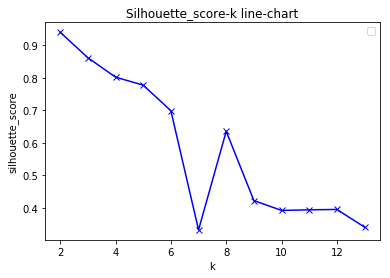

For n_cluster = 2, hash_size = 2, k = 1, vipno_input = 2900000549289:

For n_cluster = 2, hash_size = 2, k = 2, vipno_input = 1590151544861:
vipno_output: 1591011326672, result: same

For n_cluster = 2, hash_size = 2, k = 3, vipno_input = 1591150424154:
vipno_output: 1595142205462, result: same
vipno_output: 1590142175272, result: same

For n_cluster = 2, hash_size = 2, k = 4, vipno_input = 1593140967467:
vipno_output: 1595151630507, result: same
vipno_output: 1595150991142, result: same
vipno_output: 2900002512281, result: same

For n_cluster = 2, hash_size = 2, k = 5, vipno_input = 1595132332932:
vipno_output: 1591150424154, result: same
vipno_output: 1591015159689, result: same
vipno_output: 2900000771062, result: same
vipno_output: 1595142205462, result: same

For n_cluster = 2, hash_size = 14, k = 1: no result from KNN.

For n_cluster = 2, hash_size = 14, k = 2: no result from KNN.

For n_cluster = 2, hash_size = 14, k = 3: no result from KNN.

For n_cluster = 2, hash_size = 14, k

In [3]:
if __name__ == '__main__':

    evaluate_KMeans()

    validate(2)

    #for n in range(int(math.sqrt(data_shape[1])/2), int(math.sqrt(data_shape[1])/2) + 40)
    #   validate(n)